In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from collections import Counter
import random
import math
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Create tree classifier from scratch

In [24]:
import random
class DTC():
    def __init__(self, random_state = None, max_depth = None, min_sample_split = 2, criterion = "gini", min_info_gain = 0, max_features = None, max_thresholds = None, class_weights = {}):
        """
        Initializes the Decision Tree Classifier.

        Parameters:
        - random_state: int or None, optional (default=None)
            Seed for the random number generator.
        - max_depth: int or None, optional (default=None)
            The maximum depth of the decision tree. If None, the tree is grown until all leaves are pure or until all leaves contain less than min_sample_split samples.
        - min_sample_split: int, optional (default=2)
            The minimum number of samples required to split an internal node.
        - criterion: str, optional (default="gini")
            The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity, "entropy" for the information gain, and "shannon" for the Shannon entropy.
        - min_info_gain: float, optional (default=0)
            The minimum information gain required to split an internal node.
        - max_features: int, float, "sqrt", "log2", or None, optional (default=None)
            The number of features to consider when looking for the best split. If int, then consider max_features features at each split. If float, then max_features is a fraction and int(max_features * n_features) features are considered. If "sqrt", then max_features=sqrt(n_features). If "log2", then max_features=log2(n_features). If None, then all features are considered.
        - max_thresholds: int or None, optional (default=None)
            The maximum number of thresholds to consider for each feature when looking for the best split. If None, all unique feature values are considered as potential thresholds.
        - class_weights: dict, optional (default={})
            Weights associated with classes. If provided, the class probabilities are multiplied by the corresponding weight.

        Returns:
        None
        """
        
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.criterion = criterion
        self.min_info_gain = min_info_gain
        self.max_features = max_features
        self.max_thresholds = max_thresholds
        self.class_weights = class_weights
        self.tree = None
        self.random_state = random_state
        random.seed(self.random_state)

        

    def fit(self, X, y):
        """
        Fits the decision tree classifier to the training data.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The training input samples.
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        None
        """
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
        if isinstance(y, pd.DataFrame):
            y = np.array(y)

        self.tree = self.__create_tree(X, y)
       
    def __calculate_split_entropy(self, y):
        """
        Calculates the split entropy for a given target variable.

        Parameters:
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        split_criterion: float
            The split criterion value.
        """

        unique_values, value_counts = np.unique(y, return_counts=True)
        class_probabilities = value_counts / len(y)

        if len(self.class_weights) > 0 and len(unique_values) > 0:
            class_probabilities *= np.array([self.class_weights.get(value, 1.0) for value in unique_values])

        split_criteria = {
            'shannon': lambda probs: -np.sum(probs * np.log2(probs)),
            'entropy': lambda probs: -np.sum(probs * np.log2(probs + 1e-10)),
            'gini': lambda probs:  1 - np.sum(probs ** 2)
        }

        split_criterion_function = split_criteria.get(self.criterion, split_criteria['gini'])
        split_criterion = split_criterion_function(class_probabilities)

        return split_criterion


    def __calculate_info_gain(self, X, y, feature, threshold):
        """
        Calculates the information gain for a given feature and threshold.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values.
        - feature: int
            The index of the feature.
        - threshold: float
            The threshold value.

        Returns:
        info_gain: float
            The information gain.
        """

        left_indeces = X[:, feature] <= threshold
        right_indeces = X[:, feature] > threshold

        left_labels = y[left_indeces]
        right_labels = y[right_indeces]

        left_side_entropy = self.__calculate_split_entropy(left_labels)
        right_side_entropy = self.__calculate_split_entropy(right_labels)

        
        weighted_left_side_entropy = (len(left_labels) / len(y)) * left_side_entropy
        weighted_right_side_entropy = (len(right_labels) / len(y)) * right_side_entropy

        parent_entropy = self.__calculate_split_entropy(y)

        info_gain = parent_entropy - (weighted_left_side_entropy + weighted_right_side_entropy)

        return info_gain


    def __get_features(self, n_features):
        """
        Returns the indices of the features to consider for splitting.

        Parameters:
        - n_features: int
            The total number of features.

        Returns:
        columns_id: list
            The indices of the features to consider.
        """

        np.random.seed(self.random_state)
        if self.max_features is not None:
            if self.max_features == "sqrt":
                columns_id = np.random.choice(range(n_features), int(math.sqrt(n_features)), replace=False)
            elif self.max_features == "log2":
                columns_id = np.random.choice(range(n_features), int(math.log2(n_features)), replace=False)
            elif isinstance(self.max_features, int):
                if self.max_features > n_features:
                    raise ValueError("Max features > number of features")
                elif self.max_features <= 0:
                    raise ValueError("Max features must be > 0")
                columns_id = np.random.choice(range(n_features), self.max_features, replace=False)
            elif isinstance(self.max_features, float):
                if self.max_features > 1:
                    raise ValueError("Max features > number of features")
                elif self.max_features <= 0:
                    raise ValueError("Max features must be > 0")
                columns_id = np.random.choice(range(n_features), int(n_features * self.max_features), replace=False)
        else:
            columns_id = list(range(n_features))    

        return columns_id
    

    def __get_thresholds(self, X, feature):
        """
        Returns the thresholds to consider for a given feature.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - feature: int
            The index of the feature.

        Returns:
        thresholds: array-like
            The thresholds to consider.
        """

        if self.max_thresholds is not None:
            if self.max_thresholds <= 0:
                raise ValueError("max_thresholds must be > 0")
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, self.max_thresholds))
        else:
            unique_vals = np.unique(X[:, feature])
            thresholds = (unique_vals[1:] + unique_vals[:-1]) / 2
        return thresholds



    def __calculate_best_split(self, X, y):
        """
        Calculates the best split for the given input samples and target values.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        best_feature: int
            The index of the best feature to split on.
        best_threshold: float
            The best threshold value.
        best_info_gain: float
            The information gain of the best split.
        """

        best_threshold = None
        best_info_gain = -np.inf
        best_feature = None

        features = self.__get_features(X.shape[1])

        for feature in features:
            threholds = self.__get_thresholds(X, feature)
               
            for threshold in threholds:
                info_gain = self.__calculate_info_gain(X, y, feature, threshold)
                if best_info_gain < info_gain:
                    best_threshold = threshold
                    best_feature = feature
                    best_info_gain = info_gain

        return best_feature, best_threshold, best_info_gain


    def __create_tree(self, X, y, depth = 0):
        """
        Recursively creates the decision tree.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values.
        - depth: int, optional (default=0)
            The current depth of the tree.

        Returns:
        tree: dict
            The decision tree.
        """
        samples = X.shape[0]
        
        if samples < self.min_sample_split or (self.max_depth != None and depth >= self.max_depth):
            return self.__create_leaf_node(y)

        best_feature, best_threshold, best_info_gain = self.__calculate_best_split(X, y)

        if(best_info_gain <= self.min_info_gain):
            return self.__create_leaf_node(y)
        
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_child = self.__create_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self.__create_tree(X[right_indices], y[right_indices], depth + 1)

        if 'label' in left_child and 'label' in right_child:
            if left_child['label'] == right_child['label']:
                return {
                    'label': left_child['label'],
                    'samples': len(y)
                }


        return {
            'splitting_threshold': best_threshold,
            'splitting_feature': best_feature,
            'info_gain': best_info_gain,
            'left_child': left_child,
            'right_child': right_child
        }
    


    def __create_leaf_node(self, y):
        """
        Creates a leaf node for the decision tree.

        Parameters:
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        leaf_node: dict
            The leaf node.
        """
        majority_class = Counter(y).most_common(1)[0][0]
        return {
            'label': majority_class,
            'samples': len(y)
        }
    

    def predict(self, X):
        """
        Predicts the class labels for the input samples.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.

        Returns:
        predictions: array-like of shape (n_samples,)
            The predicted class labels.
        """

        if(isinstance(X, pd.DataFrame)):
            X = np.array(X)
        
        predictions = []
        for sample in X:
            prediction = self.__traverse_tree(sample, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def score(self, X, y):
        if(isinstance(y, pd.DataFrame)):
            y = np.array(y)


        y_pred = self.predict(X)

        
        metrics = {
            'accuracy': accuracy_score(y_pred, y),
            'recall': recall_score(y_pred, y),
            'precision': precision_score(y_pred, y),
            'f1_score': f1_score(y_pred, y),
            'roc_auc': roc_auc_score(y_pred, y)
        }

        print(metrics)
           
        return np.mean(y_pred == y)
    

    def __traverse_tree(self, sample, node):
        """
        Traverses the decision tree to predict the class label for a given sample.

        Parameters:
        - sample: array-like of shape (n_features,)
            The input sample.
        - node: dict
            The current node of the decision tree.

        Returns:
        label: int
            The predicted class label.
        """

        if 'label' in node:
            return node['label']
        else:
            if sample[node['splitting_feature']] <= node['splitting_threshold']:
                return self.__traverse_tree(sample, node['left_child'])
            else:
                return self.__traverse_tree(sample, node['right_child'])
            
    def __recursive_print(self, node, indent=""):
        """Recursively print the decision tree.

        Parameters
        ----------
        node
            The current node to be printed.
        indent : str, default=""
            The indentation string for formatting the tree.
        """
        if 'label' in node:
            print("{}leaf - label: {} ".format(indent, node['label']))
            return

        print("{}id:{} - threshold: {}".format(indent,
              node['splitting_feature'], node['splitting_threshold']))

        self.__recursive_print(node['left_child'], "{}   ".format(indent))
        self.__recursive_print(node['right_child'], "{}   ".format(indent))

    def print_tree(self):
        """Display the decision tree structure."""
        self.__recursive_print(self.tree)

    

## Load, split, train and test data

In [3]:
data = load_breast_cancer(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(np.array(data['data']), np.array(data['target']), test_size=.2, random_state=42)

In [4]:
cls_s = DecisionTreeClassifier(random_state=0)
cls_s.fit(X_train, y_train)
cls_s.score(X_test, y_test)

0.9385964912280702

In [5]:
cls_m = DTC(random_state=0)
cls_m.fit(X_train, y_train)
cls_m.score(X_test, y_test)

0.9385964912280702

# Test Decision Tree on transactions
Load transactions

In [6]:
df = pd.read_csv('./preprocessed_data/preprocessed_data_small.csv')
df.head()

,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,same_account,same_bank,same_currency,same_amount,is_laundering
0,3697.34,12,3697.34,12,5,1,1,1,1,0
1,0.01,12,0.01,12,3,0,0,1,1,0
2,14675.57,12,14675.57,12,5,1,1,1,1,0
3,2806.97,12,2806.97,12,5,1,1,1,1,0
4,36682.97,12,36682.97,12,5,1,1,1,1,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df.drop('is_laundering', axis=1)), np.array(df['is_laundering']), test_size=.2, random_state=42)

In [8]:
print(f"n_samples laundering: {np.sum(y_train)}")
print(f"n_samples not laundering: {len(y_train) - np.sum(y_train)}")

n_samples laundering: 4090
n_samples not laundering: 4058586


## Balancing dataset

In [9]:
y_laund_indeces = [i for i,x in enumerate(y_train) if x == 1]
y_not_laund_indeces = [i for i,x in enumerate(y_train) if x == 0]

X_train_l = [X_train[i] for i in y_laund_indeces]
X_train_n = [X_train[i] for i in y_not_laund_indeces]

y_train_l = [y_train[i] for i in y_laund_indeces]
y_train_n = [y_train[i] for i in y_not_laund_indeces]

X_train = np.array(X_train_l + X_train_n[:len(X_train_l)])
y_train =  np.array(y_train_l + y_train_n[:len(y_train_l)])



In [25]:
cls_m = DTC(random_state=0, max_depth=5, max_features=None, max_thresholds=4, min_sample_split=2, criterion='entropy')
cls_m.fit(X_train, y_train)
cls_m.score(X_test, y_test)
y_pred = cls_m.predict(X_test)

{'accuracy': 0.9233313215230552, 'recall': 0.011763508959342769, 'precision': 0.8509659613615456, 'f1_score': 0.023206221776216757, 'roc_auc': 0.5057953116962565}


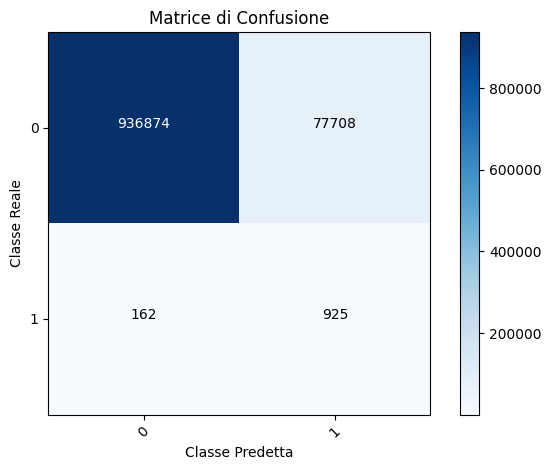

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Etichette delle classi (sostituisci con i tuoi nomi di classi reali se necessario)
class_names = ['0', '1']

# Crea il grafico della matrice di confusione
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Aggiungi i valori delle celle nella matrice
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')
plt.tight_layout()
plt.show()

# Hyperparameter tuning

In [12]:
from hyperopt import fmin, tpe, hp, Trials

In [13]:
def objective_function(params):
        dtc = DTC(**params, random_state=0)
        dtc.fit(X_train, y_train)
        return -dtc.score(X_test, y_test)  

In [22]:
choises = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40],
    'min_sample_split': [2, 5, 10],
    'criterion': ['gini', 'entropy', 'shannon'],
    'max_features': [None, 'sqrt', 'log2', .2, .4],
    'max_thresholds': [None, 2, 4, 6, 8, 10]
}

space = {
    'max_depth': hp.choice('max_depth', choises['max_depth']),
    'min_sample_split': hp.choice('min_sample_split', choises['min_sample_split']),
    'criterion': hp.choice('criterion', choises['criterion']),
    'max_features': hp.choice('max_features', choises['max_features']),
    'max_thresholds': hp.choice('max_thresholds', choises['max_thresholds'])
}

In [15]:
trials = Trials()
best = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [11:32<00:00,  6.93s/trial, best loss: -0.9233313215230552]


In [23]:
for key, value in best.items():
    print(f"{key}: {choises[key][value]}")

criterion: entropy
max_depth: 5
max_features: None
max_thresholds: 4
min_sample_split: 2


In [ ]:
cls_m.score(X_test, y_test)